In [33]:
'''

for file in atero_files[:int(len(atero_files) * 0.3)]:
  shutil.copy(DIR + "/atero_full/" + file, DIR + "/test/atero") 
for file in norm_files[:int(len(norm_files) * 0.3)]:
  shutil.copy(DIR + "/norm_full/" + file, DIR + "/test/norm") 

for file in atero_files[int(len(atero_files) * 0.3): int(len(atero_files) * 0.9)]:
  shutil.copy(DIR + "/atero_full/" + file, DIR + "/train/atero") 
for file in norm_files[int(len(norm_files) * 0.3): int(len(atero_files) * 0.9)]:
  shutil.copy(DIR + "/norm_full/" + file, DIR + "/train/norm") 

for file in atero_files[int(len(atero_files) * 0.9) :]:
  shutil.copy(DIR + "/atero_full/" + file, DIR + "/val/atero") 
for file in norm_files[int(len(norm_files) * 0.9) :]:
  shutil.copy(DIR + "/norm_full/" + file, DIR + "/val/norm") 
  '''


'\n\nfor file in atero_files[:int(len(atero_files) * 0.3)]:\n  shutil.copy(DIR + "/atero_full/" + file, DIR + "/test/atero") \nfor file in norm_files[:int(len(norm_files) * 0.3)]:\n  shutil.copy(DIR + "/norm_full/" + file, DIR + "/test/norm") \n\nfor file in atero_files[int(len(atero_files) * 0.3): int(len(atero_files) * 0.9)]:\n  shutil.copy(DIR + "/atero_full/" + file, DIR + "/train/atero") \nfor file in norm_files[int(len(norm_files) * 0.3): int(len(atero_files) * 0.9)]:\n  shutil.copy(DIR + "/norm_full/" + file, DIR + "/train/norm") \n\nfor file in atero_files[int(len(atero_files) * 0.9) :]:\n  shutil.copy(DIR + "/atero_full/" + file, DIR + "/val/atero") \nfor file in norm_files[int(len(norm_files) * 0.9) :]:\n  shutil.copy(DIR + "/norm_full/" + file, DIR + "/val/norm") \n  '

In [92]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import pickle
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
DIR = '/media/data10T_2/datasets/a_pankova'
atero_files = os.listdir(DIR + '/atero_full')
norm_files = os.listdir(DIR + '/norm_full')

In [35]:
def standartize(img):
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    return np.array(img, np.float32)

def preproc(img):
    img = img[30:-30, 30:-30]
    img = cv2.resize(img, (224,224))
   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean, std = cv2.meanStdDev(img)
    img = (img - mean[0]) / std[0]    
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def easy_preproc(img):
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

norm
atero
1146
1535


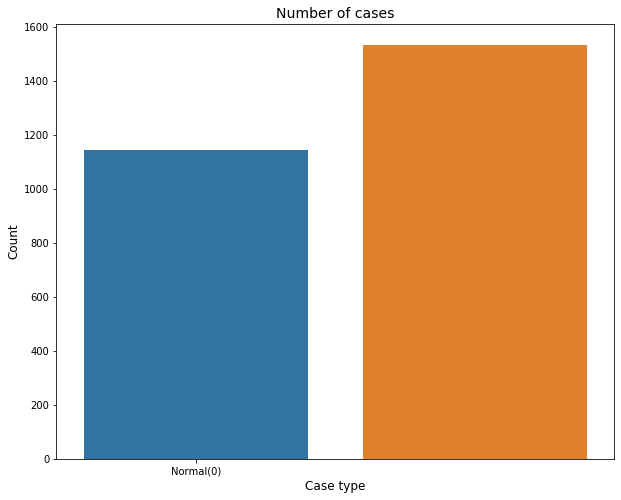

In [36]:
directory = '/media/data10T_2/datasets/a_pankova'
data_dir = Path(directory)

train_dir = data_dir / 'train'

val_dir = data_dir / 'val'

test_dir = data_dir / 'test'

atero_full = data_dir / 'atero_full'
norm_full = data_dir / 'norm_full'

all_normal = pd.DataFrame(norm_full.glob('*.png'))
all_atero = pd.DataFrame(atero_full.glob('*.png'))

all_norm_cases = []
all_atero_cases = []

for img in all_normal:
    all_norm_cases.append((img,0))
    print('norm')

for img in all_atero:
    all_atero_cases.append((img, 1))
    print('atero')

print(len(all_normal))
print(len(all_atero))


plt.figure(figsize=(10,8))
sns.barplot(x = [i for i in range(2)], y = [len(all_normal), len(all_atero)])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(0,1), ['Normal(0)', 'atero(1)'])
plt.show()


In [37]:
# Preparing test data
normal_cases_dir_test = test_dir / 'norm'
atero_cases_dir_test = test_dir / 'atero'

normal_cases_test = list(normal_cases_dir_test.glob('*.png'))
atero_cases_test = list(atero_cases_dir_test.glob('*.png'))

names_normal_test = [str(name).split('/')[-1] for name in normal_cases_test]
names_atero_test = [str(name).split('/')[-1] for name in atero_cases_test]

test_data = []
test_labels = []

for img in normal_cases_test:
    img = cv2.imread(str(img))
    try:
        #img = preproc(img)
        img = easy_preproc(img)
    except:
        continue

    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in atero_cases_test:
    img = cv2.imread(str(img))

    try:
        #img = preproc(img)
        img = easy_preproc(img)
    except:
        continue
    
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (723, 224, 224, 3)
Total number of labels: (723, 2)


In [38]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [39]:
normal_cases_dir_train = train_dir / 'norm'
atero_cases_dir_train = train_dir / 'atero'

normal_cases = normal_cases_dir_train.glob('*.png')
atero_cases = atero_cases_dir_train.glob('*.png')

train_data = []

for img in normal_cases:
    train_data.append((img,0))

for img in atero_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,/media/data10T_2/datasets/a_pankova/train/norm...,0
1,/media/data10T_2/datasets/a_pankova/train/ater...,1
2,/media/data10T_2/datasets/a_pankova/train/ater...,1
3,/media/data10T_2/datasets/a_pankova/train/ater...,1
4,/media/data10T_2/datasets/a_pankova/train/norm...,0


### How many samples for each class are there in the dataset?

1    921
0    801
Name: label, dtype: int64


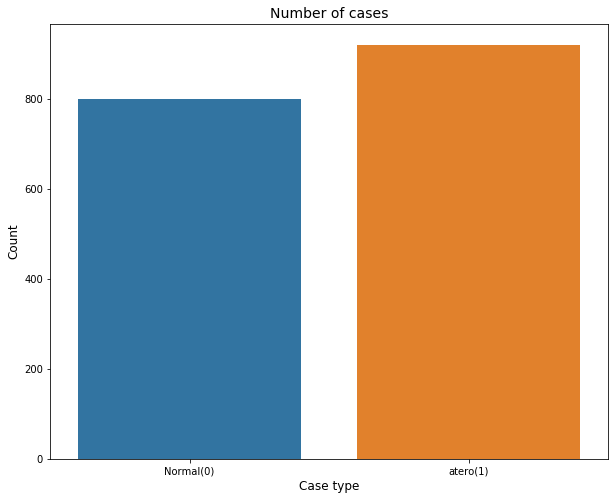

In [40]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'atero(1)'])
plt.show()

### Preparing validation data

In [41]:
normal_cases_dir_val = val_dir / 'norm'
atero_cases_dir_val = val_dir / 'atero'

normal_cases = normal_cases_dir_val.glob('*.png')
atero_cases = atero_cases_dir_val.glob('*.png')

valid_data = []
valid_labels = []


for img in normal_cases:
    img = cv2.imread(str(img))
    try:
        # img = preproc(img)
        img = easy_preproc(img)
    except:
        continue
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
for img in atero_cases:
    img = cv2.imread(str(img))
    try:
        # img = preproc(img)
        img = easy_preproc(img)
    except:
        continue

    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)

    
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (268, 224, 224, 3)
Total number of labels: (268, 2)


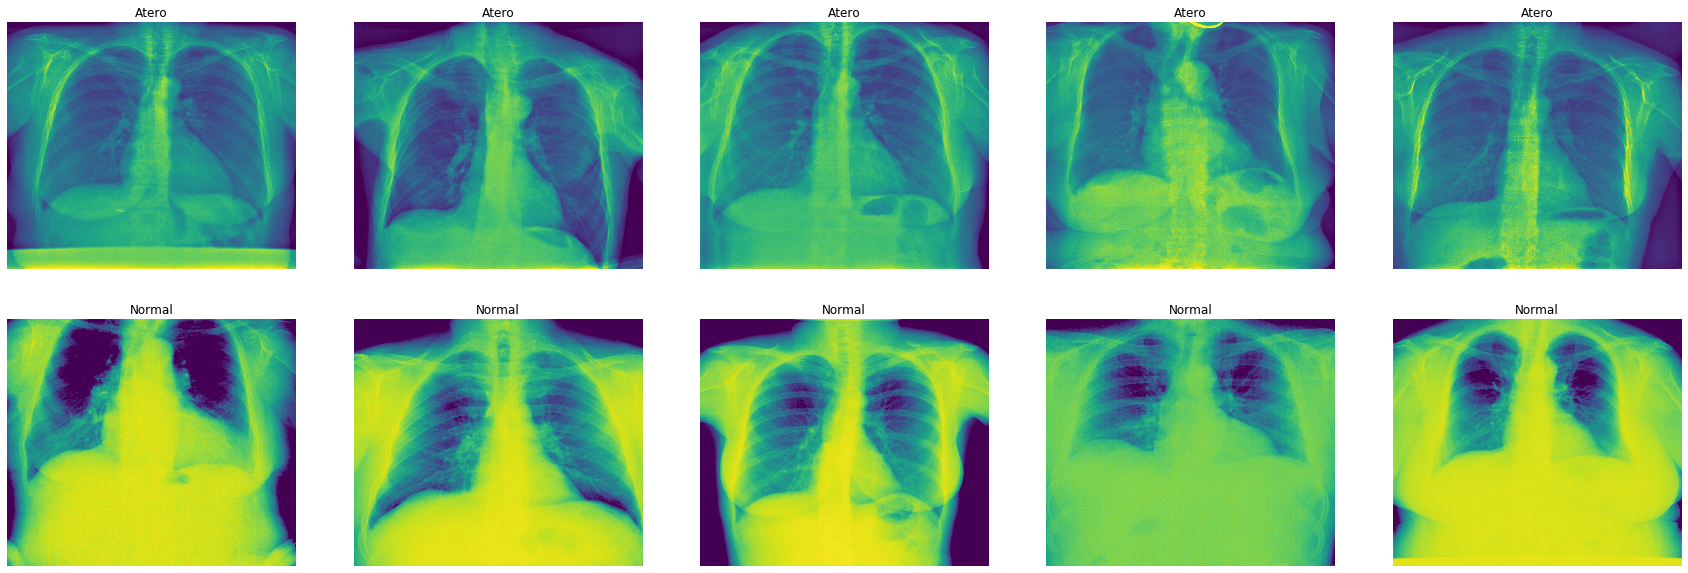

In [42]:
atero_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = atero_samples + normal_samples
del atero_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    mean, std = cv2.meanStdDev(img)
    img = (img - mean[0]) / std[0]    
    normalizedImg = np.zeros((224, 224))
    normalizedImg = cv2.normalize(img,  normalizedImg, 0, 1, cv2.NORM_MINMAX,  dtype=cv2.CV_32F)
    img = normalizedImg

    ax[i//5, i%5].imshow(img)
    if i<5:
        ax[i//5, i%5].set_title("Atero")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

## Augmentation



In [43]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # rotation
    iaa.Multiply((0.5, 1.5))]) #random brightness

### data generator 


In [44]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n // batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            try:
                img = preproc(img)
            except:
                continue

            batch_data[count] = img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if count < batch_size-2:
                aug_img1 = seq.augment_image(img.astype(np.float32))
                aug_img2 = seq.augment_image(img.astype(np.float32))
                #aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                #aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)
                aug_img2 = aug_img2.astype(np.float32)

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

## Model 

This is the best part. If you look at other kernels on this dataset, everyone is busy doing transfer learning and fine-tuning. **You should transfer learn but wisely**.  We will be doing partial transfer learning and rest of the model will be trained from scratch. I will explain this in detail but before that, I would love to share one of the best practices when it comes to building deep learning models from scratch on limited data.

1. Choose a simple architecture.
2. Initialize the first few layers from a network that is pretrained on imagenet. This is because first few layers capture general details like color blobs, patches, edges, etc. Instead of randomly initialized weights for these layers, it would be much better if you fine tune them.
3. Choose layers that introduce a lesser number of parameters. For example, `Depthwise SeparableConv` is a good replacement for `Conv` layer. It introduces lesser number of parameters as compared to normal convolution and as different filters are applied to each channel, it captures more information.  `Xception` a powerful network, is built on top of such layers only. You can read about `Xception` and `Depthwise Separable Convolutions` in [this](https://arxiv.org/abs/1610.02357) paper.
4. Use batch norm with convolutions.  As the network becomes deeper, batch norm start to play an important role.
5. Add dense layers with reasonable amount of neurons. Train with a higher learning rate and experiment with the number of neurons in the dense layers. Do it for the depth of your network too. 
6. Once you know a good depth, start training your network with a lower learning rate along with decay.  

This is all that I have done in the next code block.


In [45]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [46]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

We will initialize the weights of first two convolutions with imagenet weights,

In [47]:
# Open the VGG16 weight file
f = h5py.File(directory + '/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()  

In [48]:
#0.0001
opt = Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [49]:
batch_size = 4
nb_epochs = 25


train_data_gen = data_gen(data=train_data, batch_size=batch_size)

nb_train_steps = train_data.shape[0] // batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 430 and 268


In [50]:
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(np.array(valid_data), valid_labels),callbacks=[chkpt])

Epoch 1/25
430/430 [==============================] - 61s 142ms/step - loss: 0.6730 - acc: 0.5622 - val_loss: 2.4383 - val_acc: 0.4254
Epoch 2/25
430/430 [==============================] - 58s 134ms/step - loss: 0.5051 - acc: 0.7349 - val_loss: 0.4212 - val_acc: 0.8172
Epoch 3/25
430/430 [==============================] - 58s 134ms/step - loss: 0.3987 - acc: 0.7983 - val_loss: 0.2542 - val_acc: 0.9291
Epoch 4/25
430/430 [==============================] - 58s 134ms/step - loss: 0.3739 - acc: 0.8122 - val_loss: 0.2182 - val_acc: 0.9403
Epoch 5/25
430/430 [==============================] - 58s 134ms/step - loss: 0.3567 - acc: 0.8134 - val_loss: 0.2983 - val_acc: 0.9254
Epoch 6/25
430/430 [==============================] - 58s 135ms/step - loss: 0.3734 - acc: 0.8198 - val_loss: 0.2123 - val_acc: 0.9440
Epoch 7/25
430/430 [==============================] - 58s 134ms/step - loss: 0.3455 - acc: 0.8174 - val_loss: 0.2226 - val_acc: 0.9328
Epoch 8/25
430/430 [==============================] - 5

In [51]:
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=4)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

723/723 [==============================] - 3s 4ms/step
Loss on test set:  0.12355303861975946
Accuracy on test set:  0.9723374827109267


In [97]:
# Get predictions
preds = model.predict(test_data, batch_size=4)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(723,)
(723,)


In [98]:
print(preds)
print(accuracy_score(orig_test_labels, preds))

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 

When a particular problem includes an imbalanced dataset, then accuracy isn't a good  metric to look for. For example, if your dataset contains 95 negatives and 5 positives, having a model with 95% accuracy doesn't make sense at all. The classifier might label every example as negative and still achieve 95% accuracy. Hence,  we need to look for alternative metrics. **Precision** and **Recall** are really good metrics for such kind of problems. 

We will get the confusion matrix from our predictions and see what is the recall and precision of our model.

<Figure size 432x288 with 0 Axes>

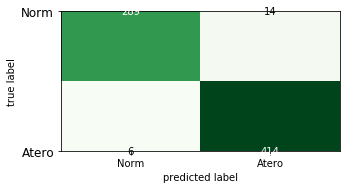

In [104]:
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(5,5), cmap=plt.cm.Greens)
plt.xticks(range(2), ['Norm', 'Atero'], fontsize=10)
plt.yticks(range(2), ['Norm', 'Atero'], fontsize=10)
plt.show()

In [55]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.97


In [56]:
#model.save(DIR + 'result_with_correct_brightness_and_correct_norm_change_096.h5')

In [93]:
preds = preds[:]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: Unknown label type: (array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       ...,


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.58431373, 0.58431373, 0.58431373],
         [0.85882353, 0.85882353, 0.85882353],
         [0.89803922, 0.89803922, 0.89803922],
         ...,
         [0.21960784, 0.21960784, 0.21960784],
         [0.19215686, 0.19215686, 0.19215686],
         [0.16470588, 0.16470588, 0.16470588]],

        [[0.96078431, 0.96078431, 0.96078431],
         [0.92941176, 0.92941176, 0.92941176],
         [0.96862745, 0.96862745, 0.96862745],
         ...,
         [0.22745098, 0.22745098, 0.22745098],
         [0.2       , 0.2       , 0.2       ],
         [0.16862745, 0.16862745, 0.16862745]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.23921569, 0.23921569, 0.23921569],
         [0.20784314, 0.20784314, 0.20784314],
         [0.17647059, 0.17647059, 0.17647059]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.75313808, 0.75313808, 0.75313808],
         [0.76150628, 0.76150628, 0.76150628],
         [0.79497908, 0.79497908, 0.79497908],
         ...,
         [0.46025105, 0.46025105, 0.46025105],
         [0.42677824, 0.42677824, 0.42677824],
         [0.40167364, 0.40167364, 0.40167364]],

        [[0.77824268, 0.77824268, 0.77824268],
         [0.79079498, 0.79079498, 0.79079498],
         [0.79916318, 0.79916318, 0.79916318],
         ...,
         [0.48535565, 0.48535565, 0.48535565],
         [0.45606695, 0.45606695, 0.45606695],
         [0.44351464, 0.44351464, 0.44351464]],

        [[0.86192469, 0.86192469, 0.86192469],
         [0.84518828, 0.84518828, 0.84518828],
         [0.85355649, 0.85355649, 0.85355649],
         ...,
         [0.53974895, 0.53974895, 0.53974895],
         [0.49790795, 0.49790795, 0.49790795],
         [0.47698745, 0.47698745, 0.47698745]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.76078431, 0.76078431, 0.76078431],
         [0.74509804, 0.74509804, 0.74509804],
         [0.77647059, 0.77647059, 0.77647059],
         ...,
         [0.9372549 , 0.9372549 , 0.9372549 ],
         [0.90980392, 0.90980392, 0.90980392],
         [0.92941176, 0.92941176, 0.92941176]],

        [[0.81176471, 0.81176471, 0.81176471],
         [0.82745098, 0.82745098, 0.82745098],
         [0.83137255, 0.83137255, 0.83137255],
         ...,
         [0.98431373, 0.98431373, 0.98431373],
         [0.98039216, 0.98039216, 0.98039216],
         [0.95686275, 0.95686275, 0.95686275]],

        [[0.88627451, 0.88627451, 0.88627451],
         [0.89411765, 0.89411765, 0.89411765],
         [0.90196078, 0.90196078, 0.90196078],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]]]]),)

In [ ]:
img = cv2.imread(DIR + '/train/atero/img_178337_3_162663.dcm.png')
f, ax = plt.subplots(2,1, figsize=(30,10))
ax[0].imshow(img)

#img = img[30:-30, 30:-30]
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mean, std = cv2.meanStdDev(img)
#img = (img - mean[0]) / std[0]    

img = (img - np.min(img)) / (np.max(img) - np.min(img))

print(np.max(img))
ax[1].imshow(img)
plt.show()
print(model.predict(np.array([img])))

In [ ]:
img = cv2.imread(DIR + '/train/norm/img_851_6_139578.dcm.png')
f, ax = plt.subplots(2,1, figsize=(30,10))
ax[0].imshow(img, cmap='gray')
plt.show()
img = img[30:-30, 30:-30]
img = cv2.resize(img, (224,224))
print(model.predict(np.array([img])))

In [ ]:
img = cv2.imread(DIR + '/train/atero/img_178337_3_162663.dcm.png')
mean, std = cv2.meanStdDev(img)
img = (img - mean[0]) / std[0]    
normalizedImg = np.zeros((224, 224))
normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)

cv2.imwrite(DIR + '/train/norm.png', normalizedImg)

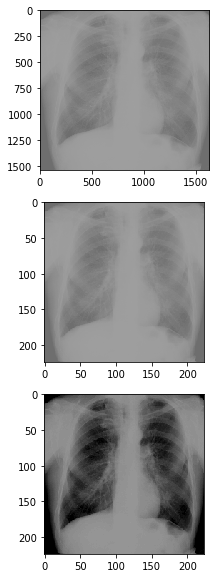

[[9.996276e-01 3.724143e-04]]


In [83]:
#img = cv2.imread(DIR + '/test_test/atero/img_183932_4_158170.dcm.png')
#img = imread(DIR + '/test_test/norm/img_502_1_32315.dcm.png')
img = imread(DIR + '/test_test/norm_decontrast.dcm.png')
#img = cv2.imread(DIR + '/test/atero/img_527482_3_169544.dcm.png')
#img = cv2.imread(DIR + '/test/norm/img_19994_3_126855.dcm.png')

#img = cv2.imread(DIR + '/test_test/atero/img_179721_3_166657.dcm.png')
#img = cv2.imread(DIR + '/test_test/atero_contrast_bright.dcm.png')

f, ax = plt.subplots(3,1, figsize=(30,10))
ax[0].imshow(img, cmap="gray", vmin=0, vmax=255)

#img = img[30:-30, 30:-30]
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mean, std = cv2.meanStdDev(img)
#img = (img - mean[0]) / std[0] 
ax[1].imshow(img, vmin=0, vmax=255)
img = cv2.normalize(img, None, alpha=0, beta=0.6, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[2].imshow(img, vmin=0, vmax=1)

plt.show()
print(model.predict(np.array([img])))



In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:-7]] 
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(np.array([img]))
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 40], cmap='gray')

layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
# Preparing test_test data
normal_cases_dir_test = Path(DIR + '/test_test') / 'norm'
atero_cases_dir_test = Path(DIR + '/test_test') / 'atero'

normal_cases_test = list(normal_cases_dir_test.glob('*.png'))
atero_cases_test = list(atero_cases_dir_test.glob('*.png'))

names_normal_test = [str(name).split('/')[-1] for name in normal_cases_test]
names_atero_test = [str(name).split('/')[-1] for name in atero_cases_test]

test_data = []
test_labels = []

for img in normal_cases_test:
    img = cv2.imread(str(img))
    try:
        img = preproc(img)
    except:
        continue

    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in atero_cases_test:
    img = cv2.imread(str(img))

    try:
        img = preproc(img)
    except:
        continue
    
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

In [ ]:
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=4)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

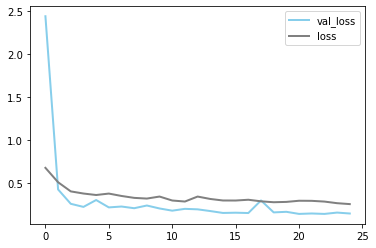

In [86]:
history_df = pd.DataFrame({'epoch': range(25), 
                           'val_loss': history.history['val_loss'], 
                           'loss': history.history['loss'], 
                           'acc': history.history['acc'], 
                           'val_acc': history.history['val_acc'] })
plt.plot( 'epoch', 'val_loss', data=history_df, color='skyblue', linewidth=2)
plt.plot( 'epoch', 'loss', data=history_df, color='grey', linewidth=2)
plt.legend()

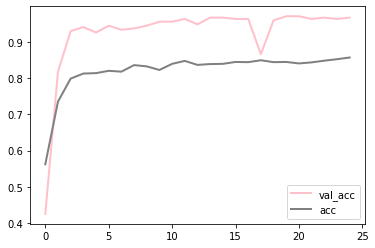

In [87]:
plt.plot( 'epoch', 'val_acc', data=history_df, color='pink', linewidth=2)
plt.plot( 'epoch', 'acc', data=history_df, color='grey', linewidth=2)
plt.legend()

In [ ]:
'''
import pydotplus
import keras
import pydot
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file=DIR + '/model.png')
'''

In [ ]:
history.history